In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
# Define the path to Excel file of refractive index
file_path = "/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250328/H2O refractive index.xlsx"

# Read the Excel file
df_full = pd.read_excel(file_path, engine='openpyxl', nrows=168)

# Extract the 2nd, 3rd, and 4th columns (indexing starts from 0)
water_nk = df_full.iloc[:, [1, 2, 3]]

# Rename the columns for clarity
water_nk.columns = ["Wavenumber (cm⁻¹)", "n (real)", "k (imag)"]

In [4]:
# Constants for Si (real index only)
n1 = 3.417  # Si
k1 = 0.0
n1_complex = n1 + 1j * k1


# Create custom angle list
angles_deg = np.concatenate([np.arange(5, 50.1, 0.1)])
angles_rad = np.radians(angles_deg)

# Prepare output dictionary
angle_dict = {}

# Loop over angles
for angle_deg, theta_i in zip(angles_deg, angles_rad):
    cos_theta_i = np.cos(theta_i)
    sin_theta_i = np.sin(theta_i)

    Rnorm_list = []
    wavenumbers = []

    # --- Pre-compute Si–Air Fresnel reflection coefficients (complex) ---
    n_air = 1 + 0j
    sin_theta_t_air = (n1_complex / n_air) * sin_theta_i
    cos_theta_t_air = np.sqrt(1 - sin_theta_t_air**2)

    rs_air = (n1_complex * cos_theta_i - n_air * cos_theta_t_air) /(n1_complex * cos_theta_i + n_air * cos_theta_t_air)
    rp_air = (n1_complex * cos_theta_t_air - n_air * cos_theta_i) / (n1_complex * cos_theta_t_air + n_air * cos_theta_i)

    denom = abs(rs_air)**2 + abs(rp_air)**2  # Denominator for normalization

    # Loop over each row in water_nk
    for _, row in water_nk.iterrows():
        wn = row[0]
        n2_complex = row[1] + 1j * row[2]  # water complex index

        # Compute transmission angle using Snell's law
        sin_theta_t = (n1_complex / n2_complex) * sin_theta_i
        cos_theta_t = np.sqrt(1 - sin_theta_t**2)

        # Compute complex Fresnel coefficients for Si–water
        rs_water = (n1_complex * cos_theta_i - n2_complex * cos_theta_t) / (n1_complex * cos_theta_i + n2_complex * cos_theta_t)
        rp_water = (n1_complex * cos_theta_t - n2_complex * cos_theta_i) / (n1_complex * cos_theta_t + n2_complex * cos_theta_i)

        num = abs(rs_water)**2 + abs(rp_water)**2  # Numerator

        Rnorm = num / denom  # Normalized reflectivity

        Rnorm_list.append(Rnorm)
        wavenumbers.append(wn)

    # Store in angle_dict
    R_data_df = pd.DataFrame({
        "wavenumber": wavenumbers,
        "Rnorm": Rnorm_list
    })
    angle_dict[angle_deg] = R_data_df


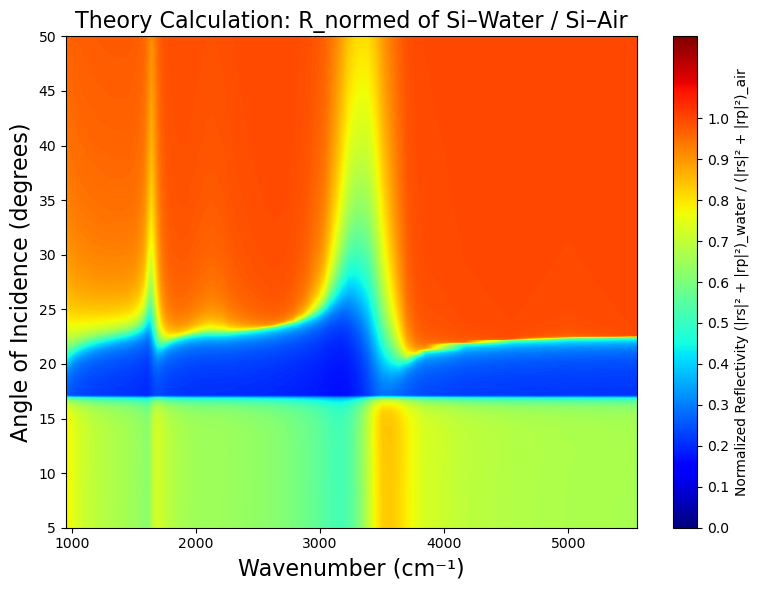

In [5]:
# Sort angles and extract wavenumbers
angles = sorted(angle_dict.keys())
wavenumbers = np.array(angle_dict[angles[0]]['wavenumber'].values)

# Clip wavenumber range
wmin, wmax = 950, 6000
mask = (wavenumbers >= wmin) & (wavenumbers <= wmax)
wavenumbers_clipped = wavenumbers[mask]

# Create 2D matrix for Rnorm
Rnorm_matrix = np.array([angle_dict[angle]['Rnorm'].values[mask] for angle in angles])

# Meshgrid
W_grid, A_grid = np.meshgrid(wavenumbers_clipped, angles)

# --- Force color levels to cover full range from 0 to 1.15 ---
levels = np.linspace(0, 1.2, 256)
plt.figure(figsize=(8, 6))  
contour = plt.contourf(W_grid, A_grid, Rnorm_matrix, levels=levels, cmap='jet', extend='neither')
cbar = plt.colorbar(contour)
cbar.set_label('Normalized Reflectivity (|rs|² + |rp|²)_water / (|rs|² + |rp|²)_air')
cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4,0.5, 0.6,0.7, 0.8, 0.9,1.0])

plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Angle of Incidence (degrees)", fontsize=16)
plt.title("Theory Calculation: R_normed of Si–Water / Si–Air", fontsize=16)
plt.tight_layout()
plt.show()

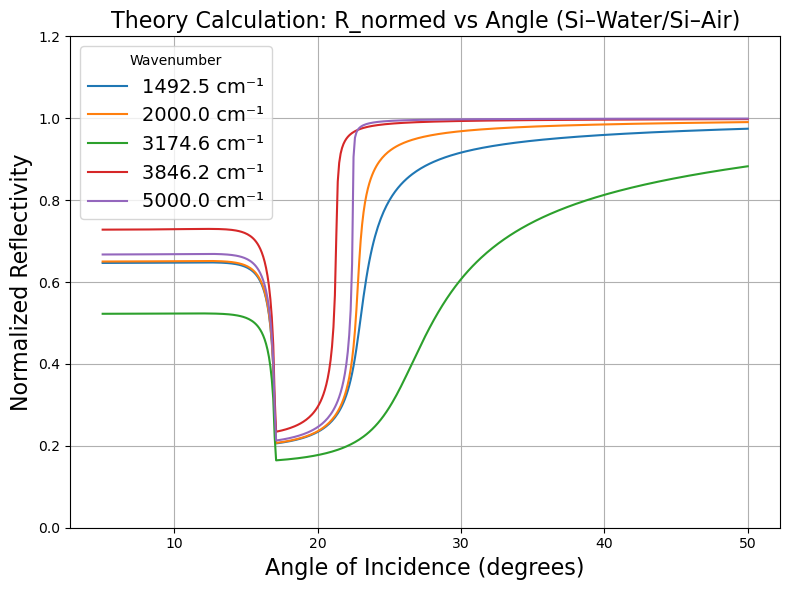

In [6]:
# Choose target wavenumbers (approximate)
target_wavenumbers = [1500, 2000,3200,4000, 5000]

# Extract sorted angle list
angles = sorted(angle_dict.keys())

# Prepare figure
plt.figure(figsize=(8, 6))

for wn_target in target_wavenumbers:
    Rnorm_values = []

    for angle in angles:
        nk_data = angle_dict[angle]
        # Find index of closest wavenumber
        idx_closest = (nk_data["wavenumber"] - wn_target).abs().idxmin()
        Rnorm = nk_data.loc[idx_closest, "Rnorm"]
        Rnorm_values.append(Rnorm)

    matched_wn = round(nk_data.loc[idx_closest, "wavenumber"], 1)
    plt.plot(angles, Rnorm_values, '-', label=f'{matched_wn} cm⁻¹')

# Customize plot
plt.title("Theory Calculation: R_normed vs Angle (Si–Water/Si–Air)", fontsize=16)
plt.xlabel("Angle of Incidence (degrees)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="Wavenumber", fontsize=14)
plt.tight_layout()
plt.show()


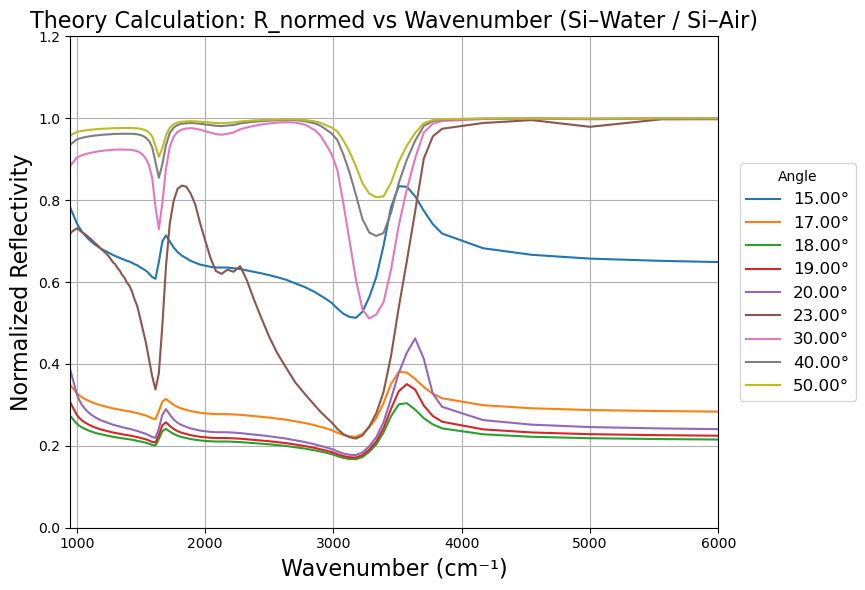

In [7]:
# Select target angles (in degrees)
target_angles = [15, 17,18, 19,20, 23, 30, 40, 50] 

# Get available angles from angle_dict
available_angles = np.array(sorted(angle_dict.keys()))

# Match target angles to the closest available in angle_dict
matched_angles = [available_angles[np.argmin(np.abs(available_angles - a))] for a in target_angles]

# Plot
plt.figure(figsize=(11, 6))

for angle in matched_angles:
    df = angle_dict[angle]
    wn = df["wavenumber"].values
    Rnorm = df["Rnorm"].values

    plt.plot(wn, Rnorm, label=f"{angle:.2f}°")

# Customize plot
plt.title("Theory Calculation: R_normed vs Wavenumber (Si–Water / Si–Air)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(950, 6000)
plt.ylim(0, 1.2)
plt.grid(True)

plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend

# plt.legend(title="Angle", fontsize=12)
# plt.tight_layout()
plt.show()


--------------------------Sliding average over angles--------------------------------

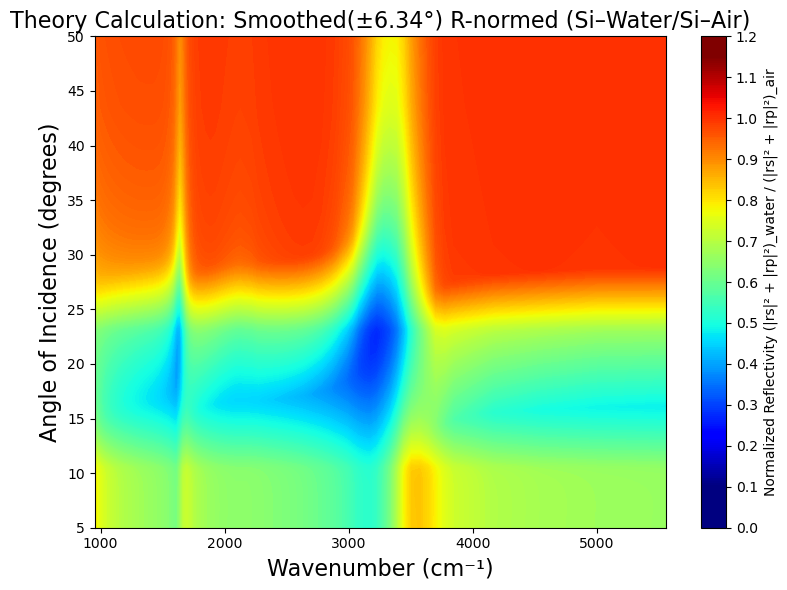

In [8]:
# --- Smoothing window  ---
window = 6.34

# --- Extract sorted angle list and wavenumbers ---
angles_all = np.array(sorted(angle_dict.keys()))
wavenumbers = np.array(angle_dict[angles_all[0]]['wavenumber'].values)

# Clip wavenumber range
wmin, wmax = 950, 6000
wn_mask = (wavenumbers >= wmin) & (wavenumbers <= wmax)
wavenumbers_clipped = wavenumbers[wn_mask]

# --- Create smoothed Rnorm matrix ---
Rnorm_smooth = []

for angle in angles_all:
    # Indices of angles within ±window degrees
    neighbor_mask = (angles_all >= angle - window) & (angles_all <= angle + window)
    neighbor_angles = angles_all[neighbor_mask]

    # Average Rnorm across neighbors
    Rnorm_avg = np.mean([angle_dict[a]['Rnorm'].values[wn_mask] for a in neighbor_angles], axis=0)
    Rnorm_smooth.append(Rnorm_avg)

# Convert to array
Rnorm_smooth = np.array(Rnorm_smooth)

# --- Meshgrid for plotting ---
W_grid, A_grid = np.meshgrid(wavenumbers_clipped, angles_all)

levels = np.linspace(0, 1.2, 256)
# --- Plot smoothed Rnorm ---
plt.figure(figsize=(8, 6))
contour = plt.contourf(W_grid, A_grid, Rnorm_smooth, levels=levels, cmap='jet', vmin=0.1, vmax=1.15)
cbar = plt.colorbar(contour)
cbar.set_label('Normalized Reflectivity (|rs|² + |rp|²)_water / (|rs|² + |rp|²)_air')
cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4,0.5, 0.6,0.7, 0.8, 0.9,1.0,1.1, 1.2])  # optional, customizable

plt.title(f"Theory Calculation: Smoothed(±{window}°) R-normed (Si–Water/Si–Air)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Angle of Incidence (degrees)", fontsize=16)
plt.tight_layout()
plt.show()


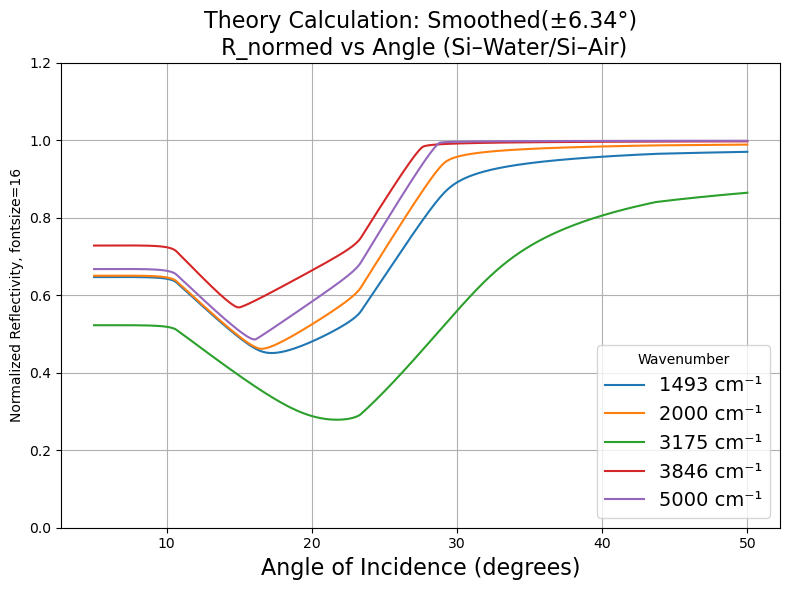

In [12]:
# --- Select target wavenumbers (approximate values) ---
target_wavenumbers = [1500, 2000,3200,4000, 5000]

# Match target wavenumbers to nearest in clipped wavenumber array
matched_wn_indices = [
    np.argmin(np.abs(wavenumbers_clipped - wn)) for wn in target_wavenumbers
]
matched_wn_values = [wavenumbers_clipped[i] for i in matched_wn_indices]

# --- Prepare figure ---
plt.figure(figsize=(8, 6))

# --- Plot Rnorm vs angle for each selected wavenumber ---
for idx, wn in zip(matched_wn_indices, matched_wn_values):
    Rnorm_curve = Rnorm_smooth[:, idx]
    plt.plot(angles_all, Rnorm_curve, label=f"{wn:.0f} cm⁻¹")

# --- Customize plot ---
plt.title(f"Theory Calculation: Smoothed(±{window}°)\n R_normed vs Angle (Si–Water/Si–Air)", fontsize=16)
plt.xlabel("Angle of Incidence (degrees)", fontsize=16)
plt.ylabel("Normalized Reflectivity, fontsize=16")
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="Wavenumber", fontsize=14)
plt.tight_layout()
plt.show()


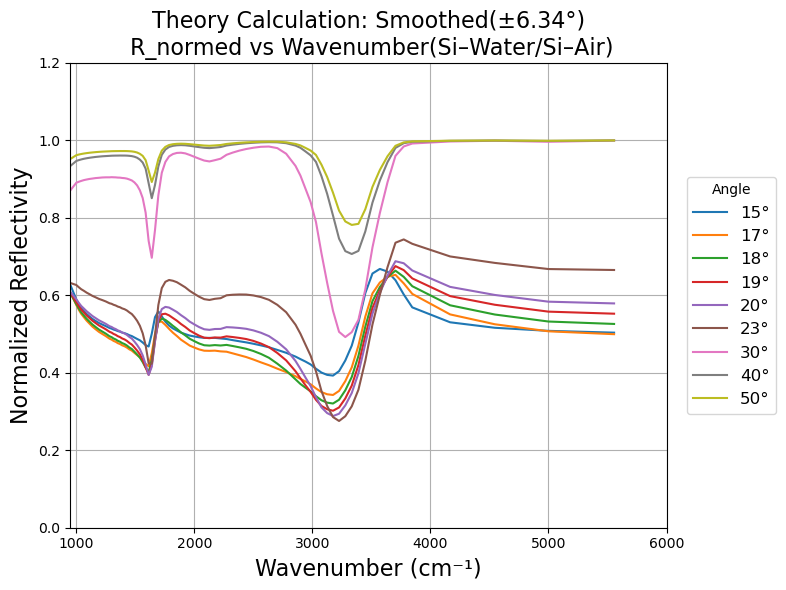

In [14]:
# --- Select target angles (in degrees) ---
target_angles = [15, 17,18, 19,20, 23, 30, 40, 50] 

# Match to closest available angles
matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in target_angles]
matched_angle_values = [angles_all[i] for i in matched_angle_indices]

# --- Plot ---
plt.figure(figsize=(10, 6))

for idx, angle in zip(matched_angle_indices, matched_angle_values):
    Rnorm_curve = Rnorm_smooth[idx, :]
    plt.plot(wavenumbers_clipped, Rnorm_curve, label=f"{angle:.0f}°")

# --- Customize plot ---
plt.title(f"Theory Calculation: Smoothed(±{window}°)\n R_normed vs Wavenumber(Si–Water/Si–Air)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(950, 6000) 
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend
plt.show()
